In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing, pathos.multiprocessing
from tqdm.notebook import tqdm
from numba import njit
from numba import prange
import os
import time

/zeus/dominik/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Q1: The stock market

(This is about numba)

A Markov Chain is defined as a sequence of random variables where a parameter depends *only* on the preceding value. This is a crucial tool in statistics, widely used in science and beyond (economics for instance).

For instance, the stock market has phases of growing prices (bull), dreasing prices (bear) and recession. This would be a Markov Chain model:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Finance_Markov_chain_example_state_space.svg/400px-Finance_Markov_chain_example_state_space.svg.png)

where the numbers on the arrows indicate the probabily that the next day will be in a given state.

Your task is to simulate the stock market according to this rule. Start from a random state and simulate many many  iterations. If your code is right, the fraction of days in each state should converge. 

Implement a pure-python version and a numba version, and compare speeds. 


In [2]:
import random


def market(state, no):
    states = ["bull", "bear", "recession"]
    pbty = {"bull": [0.9, 0.075, 0.025], "bear": [0.15, 0.8, 0.05], "recession": [0.25, 0.25, 0.5]}
    history = {"bull": 0, "bear": 0, "recession": 0}
    for n in range(no):
        state = random.choices(states, weights=pbty[state])[0]
        history[state] += 1
    return history


@njit
def market_nb(state, no):
    # ["bull", "bear", "recession"] -> [0, 1, 2]
    # pbty = ([0.9, 0.075, 0.025], [0.15, 0.8, 0.05], [0.25, 0.25, 0.5])
    pbty = [[0.9, 0.975, 1.0], [0.15, 0.95, 1.0], [0.25, 0.5, 1.0]]  # cumulative sum of pbty
    history = np.zeros(3, dtype=np.int64)
    for n in range(no):
        state = np.searchsorted(pbty[0], np.random.rand())
        history[state] += 1
    return history

In [5]:
iter = np.logspace(1, 9, 15)
python_time = []
numba_time = []
for i in iter:
    start = time.time()

    market(np.random.choice(["bull", "bear", "recession"]), int(i))
    end = time.time()
    python_time.append(end - start)
    start = time.time()
    market_nb(np.random.randint(0, 3), int(i))
    end = time.time()
    numba_time.append(end - start)
    print(int(i))

10
37
138
517
1930
7196
26826
100000
372759
1389495
5179474
19306977
71968567
268269579
1000000000


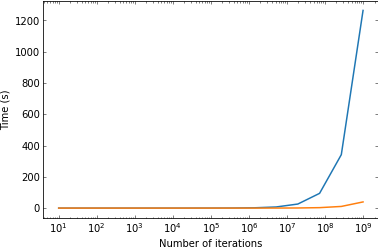

plot_times


In [6]:
@myplot  # see Q2
def plot_times(ax):
    ax.plot(iter, python_time, label="Python")
    ax.plot(iter, numba_time, label="Numba")
    ax.set_xscale("log")
    ax.set_xlabel("Number of iterations")
    ax.set_ylabel("Time (s)")


plot_times()

## Q2: Consistent plotting

(This is about python's dectorators)

Write a decorator for the plots of all your papers. 

- Remember a decorator takes a function. 
- This function in turn should return a matplotlib figure object.
- Before the function is called, the decorator should intialize a matplotlib figure with the options that you like the most (fontsize, ticks, etc etc)
- After the figure it's done, the decorator should save it to pdf.

This is a great hack for your papers! You do this once and for all, and all plots in your paper will be beautifill, all with the same style/fontsize/etc. All you'll need to do is adding `@myplot` to the relevant plotting functions. 
    
The decorator that I use for my papers is available in my python module [skywalker](https://github.com/dgerosa/skywalker).  

In [16]:
from functools import wraps
import matplotlib.pyplot as plt


def myplot(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        plt.rcParams.update(
            {
                "figure.figsize": (3.5, 2.625),
                "figure.dpi": 300,
                "xtick.direction": "in",
                "ytick.direction": "in",
                "xtick.top": True,
                "ytick.right": True,
                "xtick.major.size": 2.8,
                "xtick.major.width": 0.5,
                "xtick.minor.size": 1.5,
                "xtick.minor.width": 0.5,
                "ytick.major.size": 2.8,
                "ytick.major.width": 0.5,
                "ytick.minor.size": 1.5,
                "ytick.minor.width": 0.5,
                "savefig.bbox": "tight",
                "savefig.pad_inches": 0.01,
            }
        )
        fig, ax = plt.subplots()
        func(ax, *args, **kwargs)

        # plt.savefig(f"{func.__name__}_plot.pdf")
        plt.show()
        plt.close()
        print(func.__name__)

    return wrapper

## Q3: Scaling

(This is about multiprocessing)

The ["scaling"](https://hpc-wiki.info/hpc/Scaling) of a code refers to its performance of as a function of the number of cores adopted. 

- Define a computationally intensive task (something like an operation on two giant arrays with >1e7 numbers or, even better!, pick somethinbg from your research). 
- Make sure it's embarassingly parallel. 
- Implement a parallelization strategy using multiprocessing. 
- Plot the time the code takes as a function of the number of cores.
- Figure out the number of cores in your CPU and make sure the plot extends both below and above this number.
- Interpret the resulting features. 
- A perfect scaling result in straight line (linear dependency). How perfect is your scaling?

### Important
Numpy has some inner, semi-automatic parallelization functionalities. Some, but not all, numpy functions detect the number of CPUs in your machine and make good use of them. That's great for most applications, but when performing a scaling study you want to control the parallelization yourself and disable what's done by numpy's. The following forces numpy to use a single core.  

In [2]:
import numpy as np

np.__config__.show()
import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

openblas64__info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None), ('BLAS_SYMBOL_SUFFIX', '64_'), ('HAVE_BLAS_ILP64', None)]
    runtime_library_dirs = ['/usr/local/lib']
blas_ilp64_opt_info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None), ('BLAS_SYMBOL_SUFFIX', '64_'), ('HAVE_BLAS_ILP64', None)]
    runtime_library_dirs = ['/usr/local/lib']
openblas64__lapack_info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None), ('BLAS_SYMBOL_SUFFIX', '64_'), ('HAVE_BLAS_ILP64', None), ('HAVE_LAPACKE', None)]
    runtime_library_dirs = ['/usr/local/lib']
lapack_ilp64_opt_info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None

In [8]:
multiprocessing.cpu_count()

16

In [9]:
def some_function(arg):
    val1, val2 = arg
    result = 0
    for i in range(int(1e4)):
        result += (val1**2 + i) + (val2**2 + i)
    return result


arr1 = np.random.rand(int(5e5))
arr2 = np.random.rand(int(5e5))
args = list(zip(arr1, arr2))

In [7]:
result = []
for arg in args:
    result.append(some_function(arg))

In [10]:
exec_time = []
cpus = np.arange(1, 19)[::-1]
for cpu in cpus:
    start = time.time()
    pool = pathos.multiprocessing.ProcessPool(cpu).imap
    result = list(pool(some_function, args))
    exec_time.append(time.time() - start)
    print(cpu, exec_time[-1])

18 429.7242739200592
17 432.6820385456085
16 434.46517062187195
15 438.1324326992035
14 438.1459014415741
13 430.4384868144989
12 431.2446463108063
11 423.5031723976135
10 417.7436189651489
9 403.2594108581543
8 397.9846179485321
7 398.00626611709595
6 391.67246294021606
5 385.128071308136
4 436.65623593330383
3 579.1896204948425
2 906.8097712993622
1 1862.2822229862213


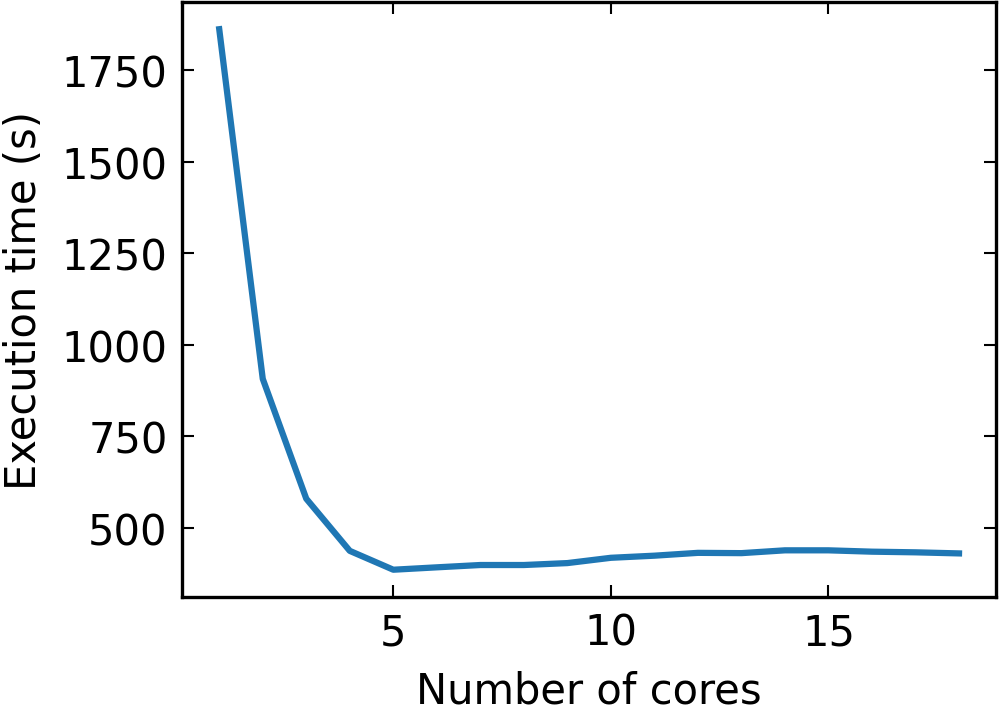

numba_plot


In [18]:
@myplot
def numba_plot(ax):
    ax.plot(cpus,exec_time)
    ax.set_ylabel('Execution time (s)')
    ax.set_xlabel('Number of cores')
numba_plot()